In [1]:
import re
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results_dir = Path("results")

In [2]:
SYSTEM_SIDE = 3
ATOL_H = 1e-6

TARGET_SEEDS = {42, 43, 44, 45, 46, 47, 48, 49, 50, 51}

In [3]:
# --- pick newest susceptibility file per seed ---

all_files = list(results_dir.glob(f"tfim_{SYSTEM_SIDE}x{SYSTEM_SIDE}_suscept_rbm_seed*_*.csv"))
parsed = []

for p in all_files:
    s_match = re.search(r"seed(\d+)", p.name)
    t_match = re.search(r"(\d{8}_\d{6})", p.name)
    if s_match and t_match:
        parsed.append({"seed": int(s_match.group(1)), "ts": t_match.group(1), "path": p})

parsed.sort(key=lambda x: x["ts"], reverse=True)

selected_map = {}
for item in parsed:
    s = item["seed"]
    if s in TARGET_SEEDS and s not in selected_map:
        selected_map[s] = item["path"]

selected_paths_susc = [selected_map[s] for s in sorted(selected_map.keys())]

print(
    f"Found {len(selected_paths_susc)} susceptibility result files overlapping with specified seed set (newest match only):")
for p in selected_paths_susc:
    print(f"  - {p.name}")

Found 3 susceptibility result files overlapping with specified seed set (newest match only):
  - tfim_3x3_suscept_rbm_seed42_20260206_035719.csv
  - tfim_3x3_suscept_rbm_seed43_20260206_035719.csv
  - tfim_3x3_suscept_rbm_seed44_20260206_035719.csv


In [4]:
dfs = [pd.read_csv(p) for p in selected_paths_susc]
all_susc_df = pd.concat(dfs, ignore_index=True)

all_susc_df = all_susc_df[["seed", "h", "chi_F"]].copy()

all_susc_df["seed"] = all_susc_df["seed"].astype(int)
all_susc_df["h"] = all_susc_df["h"].astype(float)
all_susc_df["chi_F"] = all_susc_df["chi_F"].astype(float)

print(f"\nSeeds: {sorted(all_susc_df['seed'].unique())}")


Seeds: [42, 43, 44]


In [5]:
agg_susc_df = (
    all_susc_df
    .groupby(["h"], as_index=False, observed=True)
    .agg(
        chi_F=("chi_F", "median"),
        chi_F_err=("chi_F", lambda x: x.std(ddof=0)),
        n=("chi_F", "count"),
    )
    .sort_values("h")
)

agg_susc_df.head()

,h,chi_F,chi_F_err,n
0,1.000000,0.127138,0.011323,3
1,1.071429,0.142071,0.011722,3
2,1.142857,0.159465,0.006862,3
3,1.214286,0.184122,0.007902,3
4,1.285714,0.201428,0.007802,3


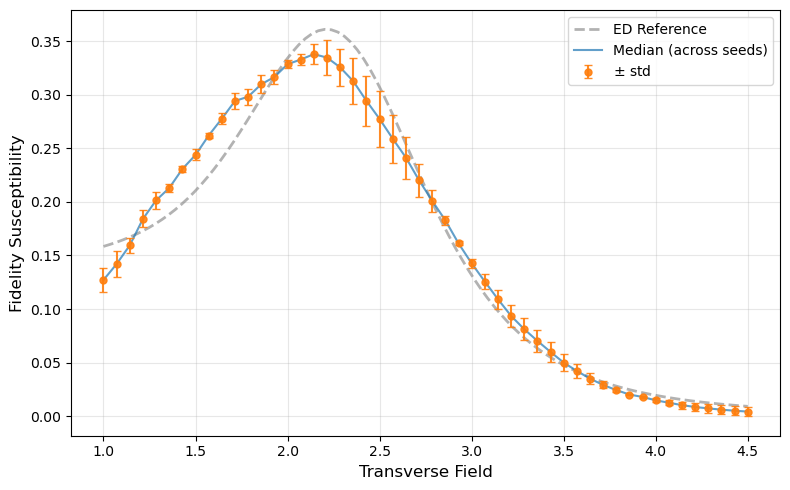

In [6]:
# --- aggregated susceptibility plot + ED overlay ---

ref_file = Path(f"tfim_{SYSTEM_SIDE}x{SYSTEM_SIDE}_suscept_ref.csv")
ref_df = pd.read_csv(ref_file) if ref_file.exists() else None

plt.figure(figsize=(8, 5), dpi=100)

# ED reference
if ref_df is not None and {"h", "chi_F"}.issubset(ref_df.columns):
    plt.plot(ref_df["h"], ref_df["chi_F"], "--", color="gray", linewidth=2, alpha=0.6, label="ED Reference")

# mean line (use agg median)
plt.plot(agg_susc_df["h"], agg_susc_df["chi_F"], "-", alpha=0.7, label="Median (across seeds)")

# error bars
plt.errorbar(
    agg_susc_df["h"], agg_susc_df["chi_F"],
    yerr=agg_susc_df["chi_F_err"],
    fmt="o",
    markersize=5,
    capsize=3,
    alpha=0.9,
    label=r"$\pm$ std"
)

plt.xlabel(r"Transverse Field", fontsize=12)
plt.ylabel(r"Fidelity Susceptibility", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [7]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = results_dir / f"tfim_{SYSTEM_SIDE}x{SYSTEM_SIDE}_suscept_rbm_err_{timestamp}.csv"

out_df = agg_susc_df[["h", "chi_F", "chi_F_err"]].copy()
out_df.to_csv(save_path, index=False, float_format="%.6e")

print(f"Saved: {save_path}")

Saved: results/tfim_3x3_suscept_rbm_err_20260206_040155.csv


In [8]:
# --- pick newest overlap file per seed ---

all_files = list(results_dir.glob(f"tfim_{SYSTEM_SIDE}x{SYSTEM_SIDE}_overlap_rbm_seed*_*.csv"))
parsed = []

for p in all_files:
    s_match = re.search(r"seed(\d+)", p.name)
    t_match = re.search(r"(\d{8}_\d{6})", p.name)
    if s_match and t_match:
        parsed.append({"seed": int(s_match.group(1)), "ts": t_match.group(1), "path": p})

parsed.sort(key=lambda x: x["ts"], reverse=True)

selected_map = {}
for item in parsed:
    s = item["seed"]
    if s in TARGET_SEEDS and s not in selected_map:
        selected_map[s] = item["path"]

selected_paths_ov = [selected_map[s] for s in sorted(selected_map.keys())]

print(f"Found {len(selected_paths_ov)} overlap result files overlapping with specified seed set (newest match only):")
for p in selected_paths_ov:
    print(f"  - {p.name}")

Found 3 overlap result files overlapping with specified seed set (newest match only):
  - tfim_3x3_overlap_rbm_seed42_20260206_035735.csv
  - tfim_3x3_overlap_rbm_seed43_20260206_035734.csv
  - tfim_3x3_overlap_rbm_seed44_20260206_035734.csv


In [9]:
dfs = [pd.read_csv(p) for p in selected_paths_ov]
all_ov_df = pd.concat(dfs, ignore_index=True)

all_ov_df = all_ov_df[["seed", "h", "overlap"]].copy()

all_ov_df["seed"] = all_ov_df["seed"].astype(int)
all_ov_df["h"] = all_ov_df["h"].astype(float)
all_ov_df["overlap"] = all_ov_df["overlap"].astype(float)

print(f"\nSeeds: {sorted(all_ov_df['seed'].unique())}")


Seeds: [42, 43, 44]


In [10]:
agg_ov_df = (
    all_ov_df
    .groupby(["h"], as_index=False, observed=True)
    .agg(
        overlap=("overlap", "median"),
        overlap_err=("overlap", lambda x: x.std(ddof=0)),
        n=("overlap", "count"),
    )
    .sort_values("h")
)

agg_ov_df.head()


,h,overlap,overlap_err,n
0,1.0,0.999921,0.000013,3
1,1.4,0.999851,0.000021,3
2,1.5,0.999820,0.000032,3
3,2.0,0.999509,0.000153,3
4,2.5,0.999613,0.000037,3


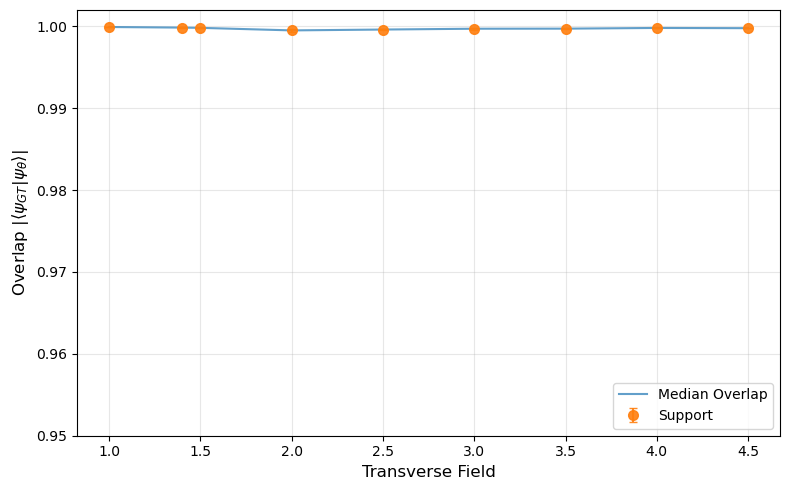

In [11]:
# --- aggregated overlap plot (support only) ---

plt.figure(figsize=(8, 5), dpi=100)

# mean line (use agg median)
plt.plot(agg_ov_df["h"], agg_ov_df["overlap"], "-", alpha=0.7, label="Median Overlap")

# error bars
plt.errorbar(
    agg_ov_df["h"], agg_ov_df["overlap"],
    yerr=agg_ov_df["overlap_err"],
    fmt="o",
    markersize=7,
    capsize=3,
    alpha=0.9,
    label="Support"
)

plt.xlabel(r"Transverse Field", fontsize=12)
plt.ylabel(r"Overlap $|\langle \psi_{GT} | \psi_{\theta} \rangle|$", fontsize=12)
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [12]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = results_dir / f"tfim_{SYSTEM_SIDE}x{SYSTEM_SIDE}_overlap_rbm_err_{timestamp}.csv"

out_df = agg_ov_df[["h", "overlap", "overlap_err"]].copy()
out_df.to_csv(save_path, index=False, float_format="%.6e")

print(f"Saved: {save_path}")

Saved: results/tfim_3x3_overlap_rbm_err_20260206_040324.csv
